# Project Description:

The purpose of this project is to implement a neural network that performs the translation of mathematical formulae from traditional **infix notation**—where the operator appears between two operands—to **postfix** (also known as Reverse Polish Notation), where the operator follows the operands.

Infix notation is the most commonly used in human-readable mathematics (e.g., a + b), but it is inherently ambiguous without additional syntactic aids such as parentheses or operator precedence rules. This ambiguity arises because different parse trees can correspond to the same expression depending on how operations are grouped.

In contrast, postfix notation eliminates the need for parentheses entirely. The order of operations is explicitly encoded by the position of the operators relative to the operands, making it more suitable for stack-based evaluation and easier to parse programmatically.

**Example:**

Consider the ambiguous infix expression:
a + b * c

This expression can be parsed in at least two different ways:

Interpretation (Infix):	(a + b) * c	   
Equivalent Postfix: ab+c*

Interpretation (Infix):	a + (b * c)	          
Equivalent Postfix: abc*+


This project aims to learn such disambiguations and generate the correct postfix form from a given infix expression using a data-driven approach based on neural networks. To simplify the task and control the complexity of expressions, we restrict our dataset to formulae with a maximum syntactic depth of 3. This means that the abstract syntax trees representing these expressions will have at most three levels, ensuring that the neural network operates on a bounded and manageable set of possible structures.

In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


We build formulae using 5 identifiers a,b,c,d,e and 4 binary operators +,-,*,/.
For simplicity we do not take advantage of precedence or associativity rules for infix notation, and suppose that all binary operations as always fully parenthesizes: (e1 op e2).

In [2]:
# -------------------- Constants --------------------
OPERATORS = ['+', '-', '*', '/']
IDENTIFIERS = list('abcde')
SPECIAL_TOKENS = ['PAD', 'SOS', 'EOS']
SYMBOLS = ['(', ')', '+', '-', '*', '/']
VOCAB = SPECIAL_TOKENS + SYMBOLS + IDENTIFIERS + ['JUNK'] #may use junk in autoregressive generation

token_to_id = {tok: i for i, tok in enumerate(VOCAB)}
id_to_token = {i: tok for tok, i in token_to_id.items()}
VOCAB_SIZE = len(VOCAB)
PAD_ID = token_to_id['PAD']
EOS_ID = token_to_id['EOS']
SOS_ID = token_to_id['SOS']

MAX_DEPTH = 3
MAX_LEN = 4*2**MAX_DEPTH -2 #enough to fit expressions at given depth (+ EOS)

In [3]:
# -------------------- Expression Generation --------------------
def generate_infix_expression(max_depth):
    if max_depth == 0:
        return random.choice(IDENTIFIERS)
    elif random.random() < 0.5:
        return generate_infix_expression(max_depth - 1)
    else:
        left = generate_infix_expression(max_depth - 1)
        right = generate_infix_expression(max_depth - 1)
        op = random.choice(OPERATORS)
        return f'({left} {op} {right})'

def tokenize(expr):
    return [c for c in expr if c in token_to_id]

def infix_to_postfix(tokens):
    precedence = {'+': 1, '-': 1, '*': 2, '/': 2}
    output, stack = [], []
    for token in tokens:
        if token in IDENTIFIERS:
            output.append(token)
        elif token in OPERATORS:
            while stack and stack[-1] in OPERATORS and precedence[stack[-1]] >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            stack.pop()
    while stack:
        output.append(stack.pop())
    return output

def encode(tokens, max_len=MAX_LEN):
    ids = [token_to_id[t] for t in tokens] + [EOS_ID]
    return ids + [PAD_ID] * (max_len - len(ids))

def decode_sequence(token_ids, id_to_token, pad_token='PAD', eos_token='EOS'):
    """
    Converts a list of token IDs into a readable string by decoding tokens.
    Stops at the first EOS token if present, and ignores PAD tokens.
    """
    tokens = []
    for token_id in token_ids:
        token = id_to_token.get(token_id, '?')
        if token == eos_token:
            break
        if token != pad_token:
            tokens.append(token)
    return ' '.join(tokens)

def generate_dataset(n,max_depth=MAX_DEPTH):
    X, Y = [], []
    for _ in range(n):
        expr = generate_infix_expression(MAX_DEPTH)
        #expr = expr_gen.generate(max_depth=max_dthep)
        infix = tokenize(expr)
        postfix = infix_to_postfix(infix)
        X.append(encode(infix))
        Y.append(encode(postfix))
    return np.array(X), np.array(Y)

#you might use the shift function for teacher-forcing
def shift_right(seqs):
    shifted = np.zeros_like(seqs)
    shifted[:, 1:] = seqs[:, :-1]
    shifted[:, 0] = SOS_ID
    return shifted

Let us define a simple dataset, and inspect a few samples.

In [4]:
X_train, Y_train = generate_dataset(50000)
decoder_input_train = shift_right(Y_train)

# Dataset
X_val, Y_val = generate_dataset(5000)
decoder_input_val = shift_right(Y_val)

In [5]:
i =  np.random.randint(50000)
print(i)
print("infix : ",decode_sequence(X_train[i],id_to_token))
print("posfix notation: ",decode_sequence(Y_train[i],id_to_token))
print("teacher forcing : ", decode_sequence(decoder_input_train[i],id_to_token))

39980
infix :  ( ( c * ( c - c ) ) * e )
posfix notation:  c c c - * e *
teacher forcing :  SOS c c c - * e *


# Constraints
* You may use any architecture (decoder-only, encoder-decoder, or other).

* The maximum number of parameters is 2 million.

* Beam search is not allowed.

* You may adapt the formula generator to your needs, but preserve its core logic—especially the frequency distribution of formulas by depth, as it may significantly influence model performance.

* You may train your model using a pre-generated fixed dataset (e.g., an array) or directly use an on-the-fly generator.


Be sure to evalutate the generator: your model may only take as input the expression in infix format and return its translation to postifix.

If you are usuing an encoder-decoder model, generation must be done autoregressively.

# Evaluation

We shall evaluate a generated item y_pred using "prefix accuracy", the lenght of
the initial prefix of y_pred matching the ground true y_true. This will be divided by the maximum length of y_true and y_pred (up to EOS), so that a perfect match has score 1.

* It's more informative than exact match (which is often 0)

* It’s tighter than edit distance: focuses on generation flow

* Captures where the model starts to make errors



In [6]:
# -------------------- Evaluation Metric Function --------------------
def prefix_accuracy_single(y_true, y_pred, id_to_token, eos_id=EOS_ID, verbose=False):
    t_str = decode_sequence(y_true, id_to_token).split(' EOS')[0]
    p_str = decode_sequence(y_pred, id_to_token).split(' EOS')[0]
    t_tokens = t_str.strip().split()
    p_tokens = p_str.strip().split()
    max_len = max(len(t_tokens), len(p_tokens))

    match_len = sum(x == y for x, y in zip(t_tokens, p_tokens))
    score = match_len / max_len if max_len>0 else 0

    if verbose:
        print("TARGET :", ' '.join(t_tokens))
        print("PREDICT:", ' '.join(p_tokens))
        print(f"PREFIX MATCH: {match_len}/{len(t_tokens)} → {score:.2f}")

    return score

# The model (Encoder-Decoder with LSTM)
The core architecture chosen for the neural network is a sequence-to-sequence (Seq2Seq) model using an Encoder-Decoder structure with LSTM layers. A Seq2Seq model is ideal for this task, as it's designed to map an input sequence (infix expression) to an output sequence (postfix expression).

Both the encoder and decoder use the same Embedding layer. This is efficient as the input and output vocabularies are very similar, reducing the total number of parameters and allowing the model to learn a single, richer representation for each token. We use an EMBEDDING_DIM of 128 and LSTM_UNITS of 256, providing sufficient capacity for this task without being excessively large. The total parameter count is ~794k, well within the 2 million limit. mask_zero=True in the embedding layer is essential, it ensures that the padding tokens (PAD_ID) are ignored during computation, allowing the model to handle variable-length sequences effectively.

The model is compiled with the adam optimizer and sparse_categorical_crossentropy loss function, standard choices for multi-class classification (predicting the next token). We use weighted_metrics to ensure that the padding tokens are also ignored when calculating accuracy during training, providing a true measure of performance on the actual sequence data.

In [7]:
# Model Hyperparameters
EMBEDDING_DIM = 128
LSTM_UNITS = 256

# Define one embedding layer to be used by both encoder and decoder.
embedding_layer = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, name='shared_embedding')

encoder_inputs = layers.Input(shape=(None,), name='encoder_input')
encoder_embedding = embedding_layer(encoder_inputs)
_, state_h, state_c = layers.LSTM(LSTM_UNITS, return_state=True, name='encoder_lstm')(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = layers.Input(shape=(None,), name='decoder_input')
decoder_embedding = embedding_layer(decoder_inputs)
decoder_lstm = layers.LSTM(LSTM_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = layers.Dense(VOCAB_SIZE, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# We use weighted_metrics to ensure the sample_weight is applied to the accuracy metric.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              weighted_metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='masked_accuracy')])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, None, 128) │      1,920 │ encoder_input[0]… │
│ (Embedding)         │                   │            │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    394,240 │ shared_embedding… │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    394,240 │ shared_embedding… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, None, 15)  │      3,855 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 794,255 (3.03 MB)

 Trainable params: 794,255 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

# Loading Pre-trained Weights via gdown
This cell correctly loads the pre-trained weights and replaces the need for training.

In [13]:
'''
FILE_ID = '13ze8l9qED-6pP8X7yj8DJ-SDQsPgu_Ad'
!gdown $FILE_ID

try:
    model.load_weights('infix_to_postfix.weights.h5')
    print("\nModel weights loaded successfully")
except Exception as e:
    print(f"\nError loading weights: {e}")
'''

Downloading...
From: https://drive.google.com/uc?id=13ze8l9qED-6pP8X7yj8DJ-SDQsPgu_Ad
To: /content/infix_to_postfix.weights.h5
100% 9.57M/9.57M [00:00<00:00, 20.5MB/s]

Model weights loaded successfully


# Model Training
In the training, to handle padding, we create sample_weights. This is a matrix of the same shape as our target data, containing a 1.0 for every real token and a 0.0 for every PAD token. By passing this to model.fit(), we instruct Keras to only compute the loss and metrics for the non-padded parts of the sequences.

In [9]:
EPOCHS = 15
BATCH_SIZE = 128

# Create sample weights to ignore padding in metrics, weight is 1.0 for non-pad tokens, 0.0 for pad tokens.
sample_weights = np.not_equal(Y_train, PAD_ID).astype(float)
val_sample_weights = np.not_equal(Y_val, PAD_ID).astype(float)

history = model.fit([X_train, decoder_input_train], Y_train,
                    sample_weight=sample_weights,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=([X_val, decoder_input_val], Y_val, val_sample_weights),
                    verbose=1)

Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 1.2452 - masked_accuracy: 0.4538 - val_loss: 0.1565 - val_masked_accuracy: 0.9449
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1103 - masked_accuracy: 0.9641 - val_loss: 0.0432 - val_masked_accuracy: 0.9888
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0317 - masked_accuracy: 0.9918 - val_loss: 0.0165 - val_masked_accuracy: 0.9962
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0156 - masked_accuracy: 0.9962 - val_loss: 0.0109 - val_masked_accuracy: 0.9975
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0088 - masked_accuracy: 0.9983 - val_loss: 0.0070 - val_masked_accuracy: 0.9985
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0050 - masked_accuracy: 0.9992 - val_loss: 0.0046 - val_masked_accuracy: 0.9990
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0042 - masked_accuracy: 0.9992 - val_loss: 0.0122 - val_masked_accuracy: 0.995

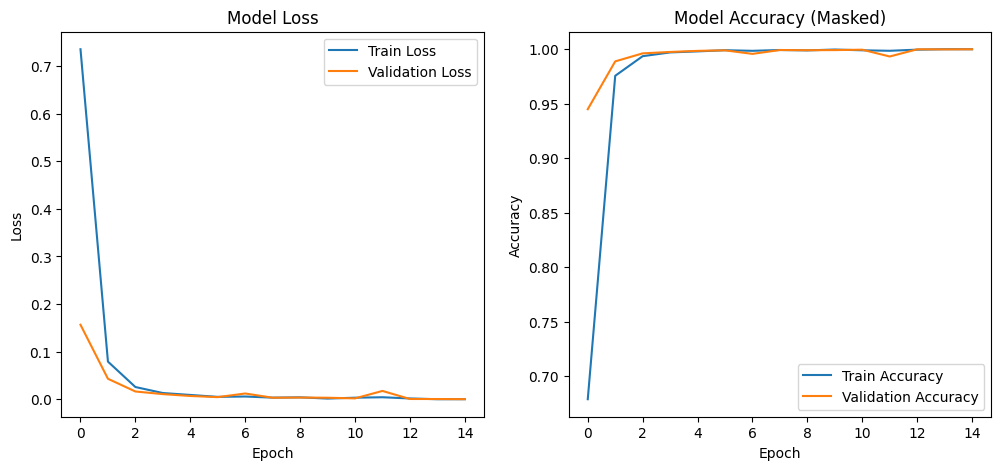

In [10]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['masked_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_masked_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy (Masked)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history)

The Model Loss plot shows both curves decrease rapidly and converge to near-zero values. The validation loss closely follows the training loss, which indicates that the model is not overfitting and is generalizing well to unseen data.

The Model Accuracy (Masked) plot shows both training and validation accuracy quickly approach 1.0, confirming that the model has effectively mastered the translation task on the dataset.

# Autoregressive Inference Setup

During training, we used teacher forcing, but for inference, the target sequence is unknown. Therefore, we must generate it autoregressively one token at a time. This requires restructuring the model into two separate parts for inference: encoder_model takes an input sequence and outputs only the final context vector (LSTM states), decoder_model takes the context vector from the encoder and the single previously predicted token to generate the probabilities for the next token, along with the updated states.

The autoregressive_decode function implements this logic:



1.   The input infix expression is encoded to get an initial context vector.
2.   The generation starts with the SOS token.
3.   In a loop, the decoder predicts the next token based on the current input token and context.
4.   The most likely token (via argmax, a greedy search) is chosen.
5.   This new token is appended to the output and becomes the input for the next step, and the context vector is updated.
6.   The process repeats until an EOS token is generated or the maximum length is reached.

In [11]:
# Inference Encoder Model
encoder_model = models.Model(encoder_inputs, encoder_states)

# Inference Decoder Model
decoder_state_input_h = layers.Input(shape=(LSTM_UNITS,))
decoder_state_input_c = layers.Input(shape=(LSTM_UNITS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# We need the embedding layer's output, we are using the same layer instance from the trained model
inf_decoder_embedding = embedding_layer(decoder_inputs)

# We use the states from the inputs to the model
inf_decoder_outputs, inf_state_h, inf_state_c = decoder_lstm(
    inf_decoder_embedding, initial_state=decoder_states_inputs)
inf_decoder_states = [inf_state_h, inf_state_c]

inf_decoder_outputs = decoder_dense(inf_decoder_outputs)

decoder_model = models.Model(
    [decoder_inputs] + decoder_states_inputs,
    [inf_decoder_outputs] + inf_decoder_states)

def autoregressive_decode(encoder_input_sequence):
    encoder_input_sequence = np.array([encoder_input_sequence])
    states_value = encoder_model.predict(encoder_input_sequence, verbose=0)

    target_seq = np.array([[SOS_ID]])

    decoded_ids = []
    for _ in range(MAX_LEN):
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0)

        predicted_token_id = np.argmax(output_tokens[0, -1, :])

        if predicted_token_id == EOS_ID:
            break

        decoded_ids.append(predicted_token_id)

        target_seq = np.array([[predicted_token_id]])
        states_value = [h, c]

    return decoded_ids + [EOS_ID] + [PAD_ID] * (MAX_LEN - len(decoded_ids) - 1)

# Final Evaluation
For the exam, evaluate you model on a test set of 20 expressions. Repeat this evaluation 10 times, and return the mean and std for this rounds.

In [12]:
def test(no=20, rounds=10):
  rscores = []
  for i in range(rounds):
    print("Round",i+1)
    X_test, Y_test = generate_dataset(no)
    scores = []
    for j in range(no):
      encoder_input = X_test[j]
      generated = autoregressive_decode(encoder_input)
      scores.append(prefix_accuracy_single(Y_test[j], generated, id_to_token))

    mean_score = np.mean(scores)
    print(f"average prefix accuracy: {mean_score:.4f}")
    rscores.append(mean_score)

  return np.mean(rscores),np.std(rscores)

print("Final evaluation...")
res, std = test(no=20, rounds=10)
print("\n")
print(f"Final Average Prefix Accuracy: {res:.4f}")
print(f"Standard Deviation over rounds: {std:.4f}")

Final evaluation...
Round 1
average prefix accuracy: 1.0000
Round 2
average prefix accuracy: 1.0000
Round 3
average prefix accuracy: 1.0000
Round 4
average prefix accuracy: 1.0000
Round 5
average prefix accuracy: 1.0000
Round 6
average prefix accuracy: 1.0000
Round 7
average prefix accuracy: 1.0000
Round 8
average prefix accuracy: 1.0000
Round 9
average prefix accuracy: 1.0000
Round 10
average prefix accuracy: 1.0000


Final Average Prefix Accuracy: 1.0000
Standard Deviation over rounds: 0.0000


# Conclusion
The final evaluation over 10 test rounds shows a perfect prefix accuracy of 1.0000 with zero standard deviation, confirming complete generalization within the problem constraints. While limited to fully parenthesized expressions with fixed depth and vocabulary, the results demonstrate that a simple sequence-to-sequence model can deterministically solve a rule-based symbolic task when trained on sufficiently rich data.

## Other attempts
The first architecture adopted was this, a standard Encoder-Decoder model with LSTM layers. After the first run, a high accuracy score of 98.7% was immediately achieved.
To further improve performance and mitigate potential overfitting a dropout layer was introduced as a regularization technique. However, this modification did not lead to a significant improvement indicating that the model did not suffer from generalization issues.
Subsequently, another simple strategy was explored, simply increasing the size of the training dataset. The dataset was gradually expanded from 10,000 to 50,000 examples until a perfect score was achieved.